In [1]:
from time import time as ti
from matplotlib import cm
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import fromfunction
from numpy import pi
import numpy as np

In [2]:
from torch import zeros,tensor,roll,sin,sqrt,linspace
from torch import sum as tsum
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#-------------------------------------------------------------------------------
# Uncomment the next line to hard code the use of cpu
#device = torch.device('cpu')
#-------------------------------------------------------------------------------

print('Using device:', device)

Using device: cuda


In [4]:
def macroscopic(fin, nx, ny, v):
    rho = tsum(fin,axis=0).to(device)
    u = zeros((2,nx,ny)).to(device)
    for i in range(9):
        u[0,:,:] += v[i,0]*fin[i,:,:]
        u[1,:,:] += v[i,1]*fin[i,:,:]
    u /= rho
    return rho, u

In [5]:
def equilibrium(rho, u, v, t, nx, ny):
    usqr = (3/2)*(u[0]**2+u[1]**2)
    feq = zeros((9,nx,ny))
    for i in range(9):
        cu = 3*(v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i]*(1+cu+0.5*cu**2-usqr)
    return feq.to(device)

In [6]:
def obstacle_fun(cx, cy, r):
    def ret_fun(x, y):
        return (x-cx)**2+(y-cy)**2<r**2
    return ret_fun

In [7]:
def inivel( uLB, ly, d, nx, ny):
  #_,yy = torch.meshgrid(linspace(0,nx-1,nx),linspace(0,ny-1,ny))
  #yy.to(device)
  vel = zeros((d,nx,ny)).to(device)
  for dir in range(d):
    vel[dir,:,:] = (1-dir) * uLB #* (1+1e-4*sin(yy/ly*2*pi))
  return vel

In [10]:
# Velocity inside obstacle is non 0
def lbm_loop(maxIter, t_out, obstacle, fin, vel, omega, nx, ny, v, t):
    #==============================================================================
    #   Time-Stepping
    #==============================================================================
    t0 = ti()
    
    # these variables used to group indices
    col_0 = tensor([0,1,2]).long().to(device)
    col_1 = tensor([3,4,5]).long().to(device)
    col_2 = tensor([6,7,8]).long().to(device)
    
    for time in tqdm(range(maxIter)):
        # outflow boundary condition (right side) NEUMANN BC, no gradient
        fin[col_2,-1,:] = fin[col_2,-2,:]
    
        # compute macroscopic variables
        rho,u = macroscopic(fin,nx,ny,v)
    
        # inlet boundary condition (left wall)
        u[:,0,:] = vel[:,0,:]
        rho[0,:] = 1/(1-u[0,0,:])*( tsum(fin[col_1,0,:], axis = 0)+
                                    2*tsum(fin[col_2,0,:], axis = 0))
    
        # Equilibrium
        feq = equilibrium(rho,u,v,t,nx,ny)
    
        fin[col_0,0,:] = feq[col_0,0,:] + fin[col_2,0,:]-feq[col_2,0,:]
    
        # Collide
        fout = fin - omega*(fin-feq)
    
        # bounceback: 
        # refer to the lattice numbering scheme to see 8-i is always the opposite of 
        # direction i!
        for i in range(9):
            fout[i,obstacle] = fin[8-i,obstacle]
    
        # stream
        for i in range(9):
            # be careful with this -> roll cycles through an array by an axis
            # and the last element becomes the first. this implements a periodic
            # boundary in a very compact syntax, but needs to be reworked for other
            # implementations
            fin[i,:,:] = roll(  
                              roll(
                                    fout[i,:,:], v[i,0].item(), dims = 0
                                   ),
                              v[i,1].item(), dims = 1 
                              )
    
        # Output an image every t_out iterations
        if (time%t_out == 0):
            plt.clf()
            u_cpu = u.cpu()
            x_temp = int(round(5*nx/ny))
            y_temp = int(round(5))
            plt.imshow(sqrt(u_cpu[0]**2+u_cpu[1]**2).T, cmap = 'Reds')
            plt.clim(0,0.07)
            plt.colorbar()
            #plt.show()
            plt.axis('equal')
            plt.savefig("vel{0:03d}.png".format(time//t_out))
    tf = ti() - t0
    print("time to execute = ",tf)

In [9]:
def lbm_sim(maxIter, nx, ny, Re, uLB=0.04, t_out=1000):
    ly = ny-1                   # Height of the domain in lattice units
    cx,cy,r = nx//4,ny//2,ny/9  # Cylinder coordinates and radius (as integers)
    nulb = uLB*r/Re             # Viscosity in lattice units
    omega = 1 / (3*nulb+0.5)    # Relaxation frequency

    # lattice velocities
    v = tensor([ 
                [1,1],
                [1,0],
                [1,-1],
                [0,1],
                [0,0],
                [0,-1],
                [-1,1],
                [-1,0],
                [-1,-1]
                ]).int().to(device)
    
    # weights
    t = tensor([ 
                1/36,
                1/9,
                1/36,
                1/9,
                4/9,
                1/9,
                1/36,
                1/9,
                1/36
                ]).float().to(device)
    
    #------------------------------------------------------------------------------
    # instantiate the obstacle
    obstacle = tensor(fromfunction(obstacle_fun(cx,cy,r),(nx, ny))).to(device)
    #------------------------------------------------------------------------------
    # initial velocity profile
    vel = inivel(uLB, ly, 2, nx, ny)
    #--------------------------------------------------------------
    # initialize fin to equilibirum (rho = 1)
    fin = equilibrium(1,vel,v,t,nx,ny).to(device)
    #--------------------------------------------------------------
    # Run main loop
    lbm_loop(maxIter,t_out,obstacle,fin,vel,omega,nx,ny,v,t)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 118.58it/s]

time to execute =  84.34326124191284


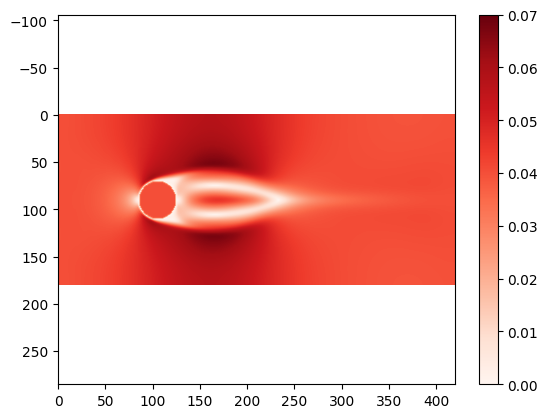

In [11]:
lbm_sim(10000, 420, 180, 150.0)